In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# return directory
print(os.listdir('/content/drive/MyDrive/skin cancer detection'))

['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'ham10000']


In [ ]:
print(torch.cuda.is_available()) # Check GPU

True


In [ ]:
data_dir = '/content/drive/MyDrive/skin cancer detection'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2


In [ ]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [ ]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/skin cancer detection/H...,Benign keratosis-like lesions,2,duplicated


In [ ]:
df_original['duplicates'].value_counts()

,count
duplicates,
unduplicated,5514
duplicated,4501


In [ ]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [ ]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [ ]:
df_val['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,883
2,88
6,46
1,35
0,30
5,13
3,8


In [ ]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [ ]:
df_train['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5822
dermatofibroma,1067
Benign keratosis-like lesions,1011
Basal cell carcinoma,479
Actinic keratoses,297
Vascular lesions,129
Dermatofibroma,107


In [ ]:
df_val['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,883
Benign keratosis-like lesions,88
dermatofibroma,46
Basal cell carcinoma,35
Actinic keratoses,30
Vascular lesions,13
Dermatofibroma,8


In [ ]:
import pandas as pd

# Define the data augmentation rates for each class
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

for i in range(7):
    if data_aug_rate[i]:
        # Repeat the subset of df_train based on data_aug_rate
        augmented_data = pd.concat([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)
        df_train = pd.concat([df_train, augmented_data], ignore_index=True)

# Check the value counts of the 'cell_type' column after augmentation
df_train['cell_type'].value_counts()


,count
cell_type,
Melanocytic nevi,5822
Dermatofibroma,5350
dermatofibroma,5335
Vascular lesions,5160
Benign keratosis-like lesions,5055
Basal cell carcinoma,4790
Actinic keratoses,4455


In [ ]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [ ]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


,count
cell_type,
Melanocytic nevi,444
Benign keratosis-like lesions,47
dermatofibroma,20
Basal cell carcinoma,15
Actinic keratoses,12
Vascular lesions,8
Dermatofibroma,6


In [ ]:
# feature_extract is a boolean that defines finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobilenet":
        model_ft = models.mobilenet_v2(pretrained=True, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
model_name = "mobilenet"
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using device: cuda')
else:
    print("Using device: cpu")
#device = torch.device('cuda:0')
# device = torch.device('cpu')
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]


Using device: cuda


In [ ]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(),
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# This function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
epoch_num = 7
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/7 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.62958], [train acc 0.52250]
[epoch 1], [iter 200 / 1124], [train loss 1.29740], [train acc 0.58688]
[epoch 1], [iter 300 / 1124], [train loss 1.13362], [train acc 0.62635]
[epoch 1], [iter 400 / 1124], [train loss 1.04481], [train acc 0.64891]
[epoch 1], [iter 500 / 1124], [train loss 0.97529], [train acc 0.66744]
[epoch 1], [iter 600 / 1124], [train loss 0.93691], [train acc 0.67661]
[epoch 1], [iter 700 / 1124], [train loss 0.89938], [train acc 0.68723]
[epoch 1], [iter 800 / 1124], [train loss 0.87185], [train acc 0.69559]
[epoch 1], [iter 900 / 1124], [train loss 0.84456], [train acc 0.70389]
[epoch 1], [iter 1000 / 1124], [train loss 0.81858], [train acc 0.71241]
[epoch 1], [iter 1100 / 1124], [train loss 0.79826], [train acc 0.71892]



0it [00:00, ?it/s]
1it [00:09,  9.13s/it]
3it [00:10,  2.78s/it]
5it [00:18,  3.41s/it]
7it [00:19,  2.14s/it]
9it [00:26,  2.83s/it]
11it [00:29,  2.30s/it]
13it [00:34,  2.30s/it]
15it [00:36,  1.98s/it]
17it [00:42,  2.29s/it]
18it [00:43,  2.39s/it]
 14%|█▍        | 1/7 [17:25<1:44:30, 1045.10s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.37657], [val acc 0.85243]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.37657], [val acc 0.85243]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.57874], [train acc 0.78219]
[epoch 2], [iter 200 / 1124], [train loss 0.56639], [train acc 0.78687]
[epoch 2], [iter 300 / 1124], [train loss 0.56149], [train acc 0.78885]
[epoch 2], [iter 400 / 1124], [train loss 0.55112], [train acc 0.79445]
[epoch 2], [iter 500 / 1124], [train loss 0.54990], [train acc 0.79519]
[epoch 2], [iter 600 / 1124], [train loss 0.54141], [train acc 0.79958]
[epoch 2], [iter 700 / 1124], [train loss 0.53738], [train acc 0.80116]
[epoch 2], [iter 800 / 1124], [train loss 0.53337], [train acc 0.80137]
[epoch 2], [iter 900 / 1124], [train loss 0.52891], [train acc 0.80337]
[epoch 2], 


0it [00:00, ?it/s]
1it [00:01,  1.82s/it]
3it [00:01,  1.90it/s]
5it [00:03,  1.60it/s]
6it [00:03,  2.02it/s]
7it [00:03,  2.48it/s]
9it [00:05,  1.76it/s]
11it [00:05,  2.57it/s]
13it [00:06,  1.98it/s]
14it [00:07,  2.33it/s]
16it [00:07,  3.39it/s]
18it [00:07,  2.34it/s]
 29%|██▊       | 2/7 [27:38<1:05:56, 791.36s/it] 

------------------------------------------------------------
[epoch 2], [val loss 0.42899], [val acc 0.85764]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.42899], [val acc 0.85764]
*****************************************************
[epoch 3], [iter 100 / 1124], [train loss 0.48640], [train acc 0.81844]
[epoch 3], [iter 200 / 1124], [train loss 0.48215], [train acc 0.81953]
[epoch 3], [iter 300 / 1124], [train loss 0.47531], [train acc 0.82260]
[epoch 3], [iter 400 / 1124], [train loss 0.47179], [train acc 0.82352]
[epoch 3], [iter 500 / 1124], [train loss 0.46240], [train acc 0.82812]
[epoch 3], [iter 600 / 1124], [train loss 0.45774], [train acc 0.83094]
[epoch 3], [iter 700 / 1124], [train loss 0.45605], [train acc 0.83125]
[epoch 3], [iter 800 / 1124], [train loss 0.45828], [train acc 0.82969]
[epoch 3], [iter 900 / 1124], [train loss 0.45621], [train acc 0.83073]
[epoch 3], 


0it [00:00, ?it/s]
1it [00:01,  1.77s/it]
3it [00:01,  1.92it/s]
5it [00:03,  1.50it/s]
7it [00:03,  2.37it/s]
9it [00:05,  1.79it/s]
11it [00:05,  2.58it/s]
13it [00:06,  2.03it/s]
14it [00:06,  2.34it/s]
16it [00:07,  3.36it/s]
18it [00:07,  2.35it/s]
 43%|████▎     | 3/7 [37:50<47:16, 709.08s/it]  

------------------------------------------------------------
[epoch 3], [val loss 0.32688], [val acc 0.89931]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 0.32688], [val acc 0.89931]
*****************************************************
[epoch 4], [iter 100 / 1124], [train loss 0.40631], [train acc 0.85000]
[epoch 4], [iter 200 / 1124], [train loss 0.40494], [train acc 0.84953]
[epoch 4], [iter 300 / 1124], [train loss 0.40614], [train acc 0.85042]
[epoch 4], [iter 400 / 1124], [train loss 0.41167], [train acc 0.84750]
[epoch 4], [iter 500 / 1124], [train loss 0.40734], [train acc 0.84919]
[epoch 4], [iter 600 / 1124], [train loss 0.40574], [train acc 0.84937]
[epoch 4], [iter 700 / 1124], [train loss 0.40454], [train acc 0.85045]
[epoch 4], [iter 800 / 1124], [train loss 0.40325], [train acc 0.85039]
[epoch 4], [iter 900 / 1124], [train loss 0.40033], [train acc 0.85229]
[epoch 4], 


0it [00:00, ?it/s]
1it [00:01,  1.83s/it]
3it [00:01,  1.91it/s]
5it [00:03,  1.56it/s]
6it [00:03,  1.99it/s]
7it [00:03,  2.55it/s]
9it [00:05,  1.78it/s]
11it [00:05,  2.65it/s]
13it [00:06,  1.97it/s]
15it [00:07,  2.82it/s]
18it [00:07,  2.35it/s]
 57%|█████▋    | 4/7 [48:04<33:35, 671.69s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.36702], [val acc 0.86111]
------------------------------------------------------------
[epoch 5], [iter 100 / 1124], [train loss 0.33267], [train acc 0.87750]
[epoch 5], [iter 200 / 1124], [train loss 0.35638], [train acc 0.86469]
[epoch 5], [iter 300 / 1124], [train loss 0.35833], [train acc 0.86385]
[epoch 5], [iter 400 / 1124], [train loss 0.35557], [train acc 0.86438]
[epoch 5], [iter 500 / 1124], [train loss 0.36311], [train acc 0.86119]
[epoch 5], [iter 600 / 1124], [train loss 0.35730], [train acc 0.86318]
[epoch 5], [iter 700 / 1124], [train loss 0.35856], [train acc 0.86366]
[epoch 5], [iter 800 / 1124], [train loss 0.36026], [train acc 0.86309]
[epoch 5], [iter 900 / 1124], [train loss 0.36197], [train acc 0.86243]
[epoch 5], [iter 1000 / 1124], [train loss 0.36065], [train acc 0.86281]
[epoch 5], [iter 1100 / 1124], [train loss 0.35867], [train acc 0.86415]



0it [00:00, ?it/s]
1it [00:01,  1.93s/it]
3it [00:02,  1.83it/s]
5it [00:03,  1.45it/s]
7it [00:03,  2.30it/s]
9it [00:05,  1.79it/s]
11it [00:05,  2.55it/s]
13it [00:07,  2.00it/s]
15it [00:07,  2.78it/s]
18it [00:08,  2.24it/s]
 71%|███████▏  | 5/7 [58:16<21:40, 650.18s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.37954], [val acc 0.86285]
------------------------------------------------------------
[epoch 6], [iter 100 / 1124], [train loss 0.32981], [train acc 0.87313]
[epoch 6], [iter 200 / 1124], [train loss 0.33110], [train acc 0.87672]
[epoch 6], [iter 300 / 1124], [train loss 0.33500], [train acc 0.87573]
[epoch 6], [iter 400 / 1124], [train loss 0.33773], [train acc 0.87469]
[epoch 6], [iter 500 / 1124], [train loss 0.33369], [train acc 0.87538]
[epoch 6], [iter 600 / 1124], [train loss 0.33121], [train acc 0.87651]
[epoch 6], [iter 700 / 1124], [train loss 0.33194], [train acc 0.87571]
[epoch 6], [iter 800 / 1124], [train loss 0.32835], [train acc 0.87723]
[epoch 6], [iter 900 / 1124], [train loss 0.32861], [train acc 0.87795]
[epoch 6], [iter 1000 / 1124], [train loss 0.32580], [train acc 0.87881]
[epoch 6], [iter 1100 / 1124], [train loss 0.32341], [train acc 0.87909]



0it [00:00, ?it/s]
1it [00:01,  1.78s/it]
3it [00:01,  1.88it/s]
5it [00:03,  1.49it/s]
7it [00:03,  2.35it/s]
9it [00:05,  1.87it/s]
11it [00:05,  2.65it/s]
13it [00:06,  1.96it/s]
16it [00:07,  3.16it/s]
18it [00:07,  2.35it/s]
 86%|████████▌ | 6/7 [1:08:24<10:36, 636.02s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.33915], [val acc 0.87153]
------------------------------------------------------------
[epoch 7], [iter 100 / 1124], [train loss 0.29286], [train acc 0.89000]
[epoch 7], [iter 200 / 1124], [train loss 0.32464], [train acc 0.88187]
[epoch 7], [iter 300 / 1124], [train loss 0.31497], [train acc 0.88271]
[epoch 7], [iter 400 / 1124], [train loss 0.31769], [train acc 0.88234]
[epoch 7], [iter 500 / 1124], [train loss 0.31392], [train acc 0.88325]
[epoch 7], [iter 600 / 1124], [train loss 0.31979], [train acc 0.88047]
[epoch 7], [iter 700 / 1124], [train loss 0.31860], [train acc 0.88062]
[epoch 7], [iter 800 / 1124], [train loss 0.31682], [train acc 0.88199]
[epoch 7], [iter 900 / 1124], [train loss 0.31217], [train acc 0.88347]
[epoch 7], [iter 1000 / 1124], [train loss 0.31076], [train acc 0.88431]
[epoch 7], [iter 1100 / 1124], [train loss 0.30846], [train acc 0.88506]



0it [00:00, ?it/s]
1it [00:01,  1.69s/it]
3it [00:01,  1.86it/s]
5it [00:03,  1.65it/s]
6it [00:03,  1.97it/s]
7it [00:03,  2.40it/s]
9it [00:05,  1.84it/s]
10it [00:05,  2.27it/s]
11it [00:05,  2.64it/s]
13it [00:06,  1.89it/s]
15it [00:07,  2.78it/s]
18it [00:07,  2.33it/s]
100%|██████████| 7/7 [1:18:39<00:00, 674.25s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.32755], [val acc 0.89757]
------------------------------------------------------------


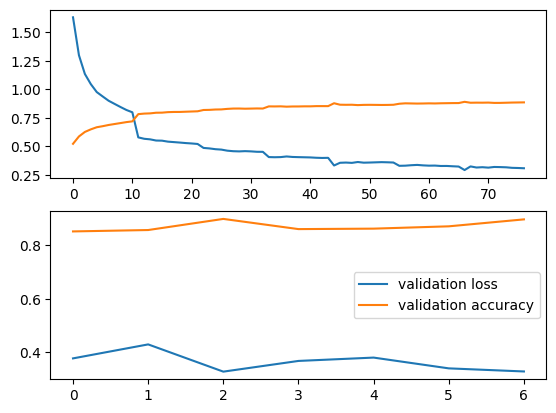

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

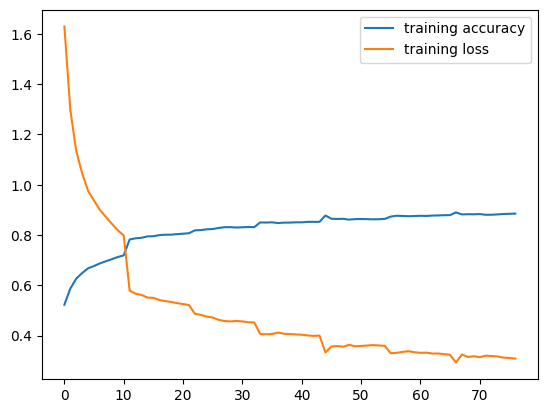

In [ ]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
#fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')
#fig2.plot(total_loss_val, label = 'validation loss')
#fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

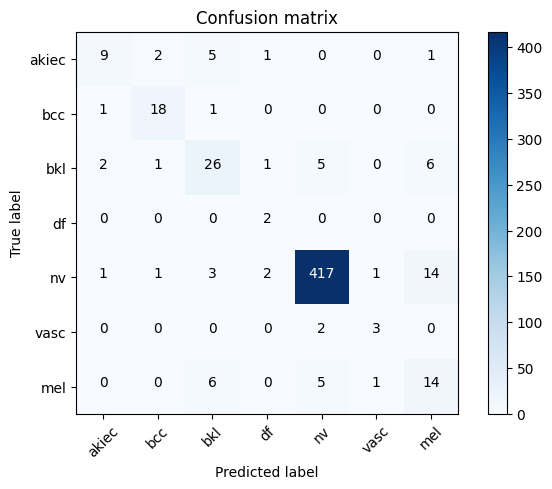

In [ ]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


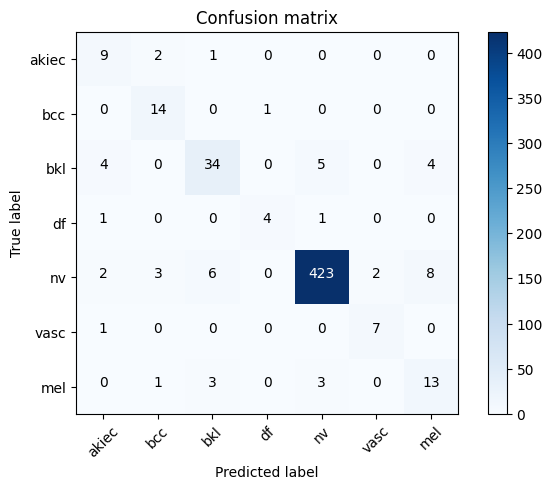

In [ ]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx_test, plot_labels)

In [ ]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.69      0.50      0.58        18
         bcc       0.82      0.90      0.86        20
         bkl       0.63      0.63      0.63        41
          df       0.33      1.00      0.50         2
          nv       0.97      0.95      0.96       439
        vasc       0.60      0.60      0.60         5
         mel       0.40      0.54      0.46        26

    accuracy                           0.89       551
   macro avg       0.64      0.73      0.66       551
weighted avg       0.90      0.89      0.89       551



In [ ]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.53      0.75      0.62        12
         bcc       0.70      0.93      0.80        15
         bkl       0.77      0.72      0.75        47
          df       0.80      0.67      0.73         6
          nv       0.98      0.95      0.97       444
        vasc       0.78      0.88      0.82         8
         mel       0.52      0.65      0.58        20

    accuracy                           0.91       552
   macro avg       0.73      0.79      0.75       552
weighted avg       0.92      0.91      0.92       552



Text(0, 0.5, 'Fraction classified incorrectly')

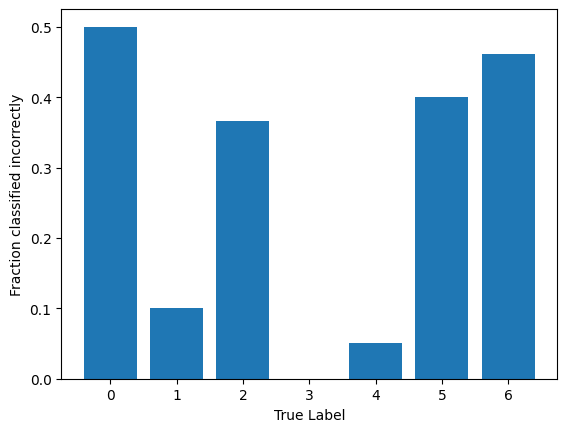

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

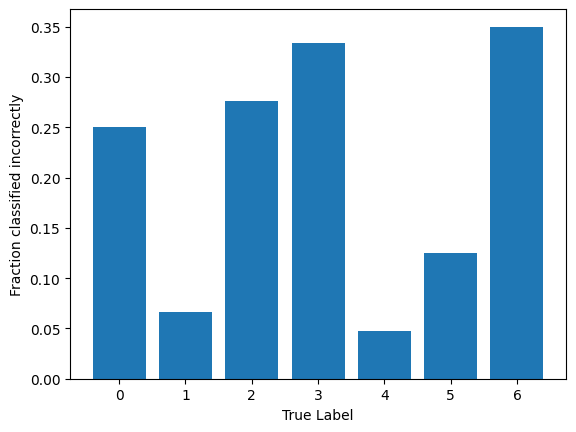

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')